In [6]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


In [7]:
from dask.distributed import Client, progress
client = Client(n_workers=3, memory_limit='4GB')  # Adjust the number of workers based on your system's resources
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:34595
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36213'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40273'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41185'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:41273', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:41273
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:55028
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:37141', name: 2, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 3,Total memory: 11.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34595,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 3
Started: Just now,Total memory: 11.18 GiB
Comm: tcp://127.0.0.1:41273,Total threads: 1
Dashboard: http://127.0.0.1:46227/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:36213,


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import dask.dataframe as dd

In [9]:
test_df = dd.read_csv('test.csv')
oil_df = dd.read_csv('oil.csv')
transaction_df = dd.read_csv('transactions.csv')
stores_df = dd.read_csv('stores.csv')
holiday_event_df = dd.read_csv('holidays_events.csv')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
train_df = dd.read_csv('/content/drive/My Drive/ARIMA/train.csv')

In [12]:
# Merging datasets holiday_event_df, stores_df, oil_df & train_df

train_df = train_df.merge(stores_df, on ='store_nbr')
train_df = train_df.merge(oil_df, on ='date', how='left')
holiday_event_df = holiday_event_df.rename(columns={'type': 'holiday_type'})
train_df = train_df.merge(holiday_event_df, on='date', how='left')

In [13]:
train_df = train_df.rename(columns={'dcoilwtico': 'crude_oil_price'})

In [14]:
train_df.isna().sum().compute()

id                       0
date                     0
store_nbr                0
family                   0
sales                    0
onpromotion              0
city                     0
state                    0
type                     0
cluster                  0
crude_oil_price     955152
holiday_type       2551824
locale             2551824
locale_name        2551824
description        2551824
transferred        2551824
dtype: int64

In [15]:
# Display the unique categories in the 'holiday_type' column
unique_holiday_types = train_df['holiday_type'].unique().compute()
print(unique_holiday_types)

0       Holiday
1          <NA>
2      Work Day
3    Additional
4         Event
5      Transfer
6        Bridge
Name: holiday_type, dtype: string


In [16]:
# Replacing NA in holiday_type

def map_holiday_type(x):
    if pd.isna(x) or x == '':
        return 'Working'
    elif x == 'Work Day':
        return 'local_holiday'
    else:
        return x

train_df['holiday_type'] = train_df['holiday_type'].apply(
map_holiday_type,
    meta=('holiday_type', 'object')
)


In [17]:
missing_counts = train_df.isna().sum()

# Calculate the percentage of missing values for each column
missing_percentages = (missing_counts / len(train_df)) * 100

# Compute the result
missing_percentages_result = missing_percentages.compute()

# Print the result
print(missing_percentages_result)

id                  0.000000
date                0.000000
store_nbr           0.000000
family              0.000000
sales               0.000000
onpromotion         0.000000
city                0.000000
state               0.000000
type                0.000000
cluster             0.000000
crude_oil_price    31.271879
holiday_type        0.000000
locale             83.547258
locale_name        83.547258
description        83.547258
transferred        83.547258
dtype: float64


In [18]:
columns_to_delete = missing_percentages[missing_percentages > 32].index

# Drop the columns with more than 32% missing values
train_df = train_df.drop(columns=list(columns_to_delete))

In [19]:
train_df = train_df.rename(columns={'family': 'product_category'})

In [20]:
# fill missing crude oil prices by forward and backward fill

train_df['crude_oil_price'] = train_df['crude_oil_price'].ffill().bfill()

# Trigger the computation to persist the changes
train_df = train_df.compute()

In [21]:
null_counts = train_df.isna().sum()

# Display the null value counts
print(null_counts)

id                  0
date                0
store_nbr           0
product_category    0
sales               0
onpromotion         0
city                0
state               0
type                0
cluster             0
crude_oil_price     0
holiday_type        0
dtype: int64


it is generally safe to say that an increase in crude oil prices can reduce the purchasing power of the public, which can give us an idea about how sales and crud_oil_price may be correlated.



In [22]:
correlation = train_df['crude_oil_price'].corr(train_df['sales'])

# Display the correlation
print(f"The correlation between crude oil prices and sales is: {correlation:.2f}")


The correlation between crude oil prices and sales is: -0.08


A correlation coefficient of -0.08 indicates a very weak negative linear relationship between crude_oil_price and transactions

primary goal is to build a predictive model for sales and the correlation with crude_oil_price does not significantly improve the predictive accuracy or explain variability in sales, thus we are to consider focusing on other variables with stronger relationships.

In [23]:
train_df.drop(columns=['crude_oil_price'])

,id,date,store_nbr,product_category,sales,onpromotion,city,state,type,cluster,holiday_type
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,Holiday
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,Holiday
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,Holiday
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,Holiday
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,Holiday
...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,Holiday
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,Holiday
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,Holiday
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,Holiday


In [24]:
train_df.duplicated().any()

True

In [25]:
dupes=train_df.duplicated()

#dupes
sum(dupes)

30294

In [26]:
#dropping duplicate values

train_df = train_df.drop_duplicates()
train_df

,id,date,store_nbr,product_category,sales,onpromotion,city,state,type,cluster,crude_oil_price,holiday_type
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,93.14,Holiday
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,93.14,Holiday
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,93.14,Holiday
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,93.14,Holiday
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,93.14,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday


### 1. Does the type of stores affect the store sales?

'''To answer the first question 'Does the type of stores affect the store sales?' , i will use ANOVA test.
ANOVA (Analysis of Variance) is a statistical test used to determine whether there are significant differences between the means of two or more groups. It compares the variation between the groups (due to the different categories or factors) to the variation within the groups.


H0 (>0.05)= The type of stores does not affect store sales. There is no significant difference in store sales between different types of stores.

H1 (<0.05)= The type of stores does affect store sales. There is a significant difference in store sales between different types of stores.
'''

In [27]:
grouped_data = train_df.groupby('type')['sales']

# Perform the ANOVA test
f_statistic, p_value = stats.f_oneway(*[grouped_data.get_group(type) for type in grouped_data.groups])

# Print the results
print("F-Statistic:", f_statistic)
print("p-value:", p_value)


F-Statistic: 17854.268189213006
p-value: 0.0


'''Based on the F-statistics and p-value above, we reject null hypothesis and accept alternative hypothesis. Hence, the type of stores does affect the store sales. There is a significant difference in store sales between different type. '''




INFO:distributed.core:Event loop was unresponsive in Scheduler for 6.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


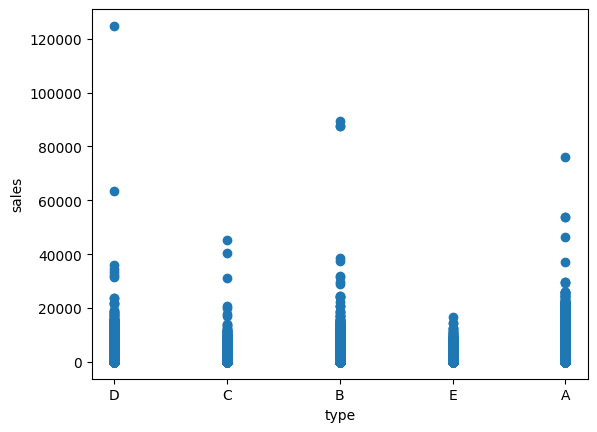

In [28]:
# Sales Vs Type

plt.scatter(train_df['type'], train_df['sales'])

plt.ylabel('sales')
plt.xlabel('type')

plt.show()


### 2. Which Product Category is having the highest sales?

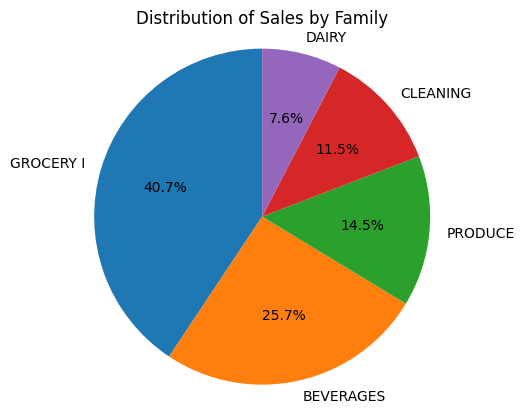

In [29]:
#Pie chart

# Group the data by product_category and calculate the total sales for each product_category
product_category_sales = train_df.groupby('product_category')['sales'].sum()

# Sort the product_category based on sales in descending order
product_category_sales_sorted = product_category_sales.sort_values(ascending=False)

# Get the top 5 families with the highest sales
top_product_category = product_category_sales_sorted.head(5)

# Create the pie chart
plt.pie(top_product_category, labels=top_product_category.index, autopct='%1.1f%%', startangle=90)

plt.title('Distribution of Sales by Family')

plt.axis('equal')
plt.show()

'''Based on the pie chart above, the GROCERY I is having the highest sales, and Baverages comes second highest. '''

### 3. Does promotion able to improve the sales?

To answer the 3rd question "Does promotion able to improve the sales?" I will use Pearson correlation test to determine the relationship between the two variables, as both of the variables are numericals. The Pearson correlation coefficient measures the linear relationship between two continuous variables and ranges from -1 to +1.

H0 (>0.05)= The promotion does not affect store sales.

H1 (<0.05)= The promotion does affect store sales.


In [30]:
correlation, p_value = pearsonr(train_df['onpromotion'], train_df['sales'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.4276134047139325
p-value: 0.0


Based on the Pearson correlation coefficient of 0.4279 and the p-value of 0.0, we can reject the null hypothesis (H0) and conclude that there is a significant relationship between promotion and store sales. Therefore, the promotion does affect store sales.

### 4. Which city is having the most most number of customers?

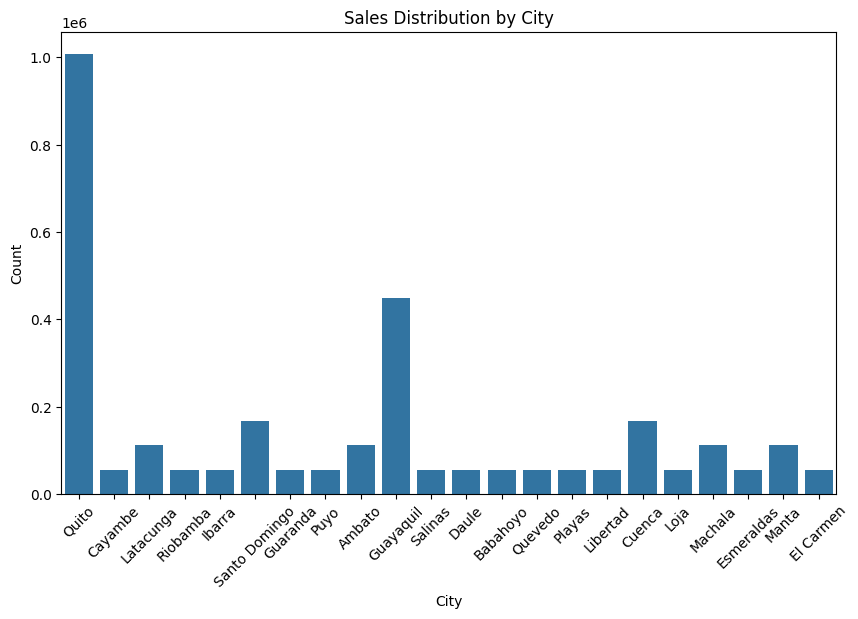

In [31]:
#Count Plot

# Create a count plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(data=train_df, x='city')

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Sales Distribution by City')

plt.xticks(rotation=45)

plt.show()

Based on the count plot above, the Quito city has the most sales.

### 5. Which state is having the most number of customers?


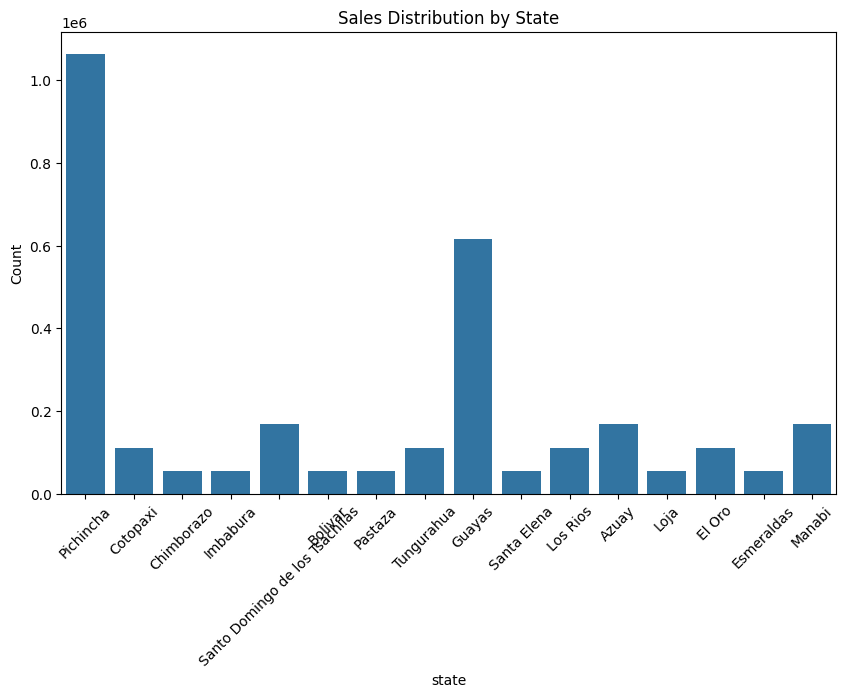

In [32]:
#Count Plot

# Create a count plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(data=train_df, x='state')

plt.xlabel('state')
plt.ylabel('Count')
plt.title('Sales Distribution by State')

plt.xticks(rotation=45)

plt.show()

Based on the count plot above, Pichincha state has the most sales as compared to other states.

### 6. Which of the stores has the highest sales.

In [33]:
store_sales = train_df.groupby(['store_nbr', 'state', 'city'])['sales'].sum().reset_index()

# Sort the stores based on sales in descending order
store_sales_sorted = store_sales.sort_values('sales', ascending=False)

# Get the top 10 stores based on sales
top_10_stores = store_sales_sorted.head(10)

# Display the top 10 stores in a table with index, state, and city
print(top_10_stores[['store_nbr', 'state', 'city', 'sales']].reset_index(drop=True))

   store_nbr       state       city         sales
0         44   Pichincha      Quito  6.271573e+07
1         45   Pichincha      Quito  5.510267e+07
2         47   Pichincha      Quito  5.148338e+07
3          3   Pichincha      Quito  5.098615e+07
4         49   Pichincha      Quito  4.387698e+07
5         46   Pichincha      Quito  4.235122e+07
6         48   Pichincha      Quito  3.634168e+07
7         51      Guayas  Guayaquil  3.324657e+07
8          8   Pichincha      Quito  3.080346e+07
9         50  Tungurahua     Ambato  2.896707e+07


### 7. Which month is having the most sales, and least sales.

In [34]:
#First convert the 'date' from object to date time

train_df['date']= pd.to_datetime(train_df['date'])


# create new columns 'month' 'year'
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year

INFO:distributed.utils_perf:full garbage collection released 187.36 MiB from 8382 reference cycles (threshold: 9.54 MiB)


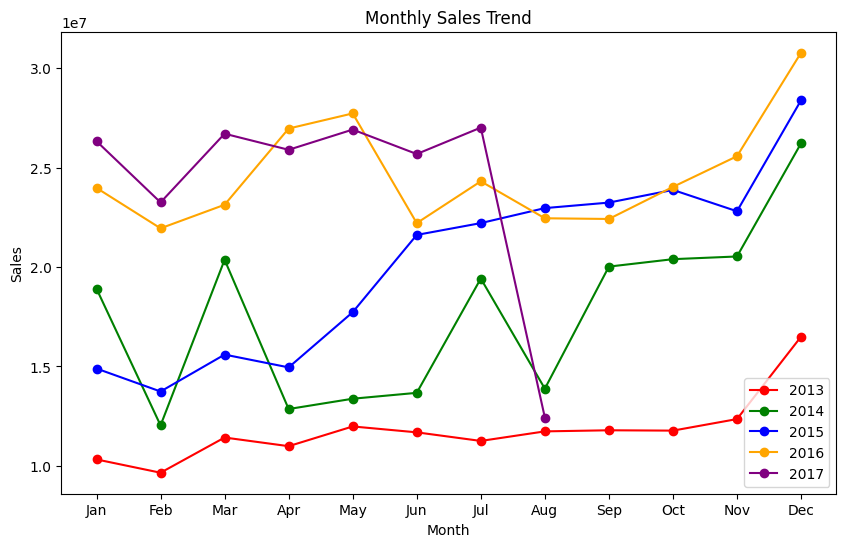

In [35]:
# Group the data by month, year, and calculate the total sales
monthly_sales = train_df.groupby(['month', 'year'])['sales'].sum().reset_index()

# Create the line chart
plt.figure(figsize=(10, 6))  # Set the figure size

# Get unique years and cycle through colors
years = monthly_sales['year'].unique()
colors = itertools.cycle(['red', 'green', 'blue', 'orange', 'purple'])

for year in years:
    year_data = monthly_sales[monthly_sales['year'] == year]
    plt.plot(year_data['month'], year_data['sales'], marker='o', color=next(colors), label=str(year))

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Trend')

# Customize x-axis ticks to show month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)


plt.legend()

plt.show()

Overall, the orange line which is 2016 has a stable high sales since January to Dec. Between the months in 2016, December had the most sales. In other hand, in comparing to other years, 2013 had an overall lowest sales achieved, especially during February.

###Does Holiday Type Affect Sales?

In [36]:
grouped_data = train_df.groupby('holiday_type')['sales']

# Perform the ANOVA test
f_statistic, p_value = stats.f_oneway(*[grouped_data.get_group(holiday_type) for holiday_type in grouped_data.groups])

# Print the results
print("F-Statistic:", f_statistic)
print("p-value:", p_value)

F-Statistic: 258.817970058415
p-value: 0.0


ANOVA test suggests that there are statistically significant differences in the mean sales across different holiday types. The low p-value implies that the observed differences in sales among holiday types are unlikely to have occurred by chance alone.

Therefore, we can conclude that the holiday type does indeed affect sales. The specific nature of the effect (i.e., which holiday types have higher or lower sales compared to others) can be further investigated through post-hoc tests or by examining the descriptive statistics of sales for each holiday type.

In [37]:
train_df = train_df.drop('crude_oil_price', axis=1)

In [38]:
train_df = train_df.drop('cluster', axis=1)

In [39]:
train_df = train_df.drop('state', axis=1)

In [40]:
train_df = train_df.drop('city', axis=1)

In [41]:
train_df.head()

,id,date,store_nbr,product_category,sales,onpromotion,type,holiday_type,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,D,Holiday,1,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,D,Holiday,1,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,D,Holiday,1,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,D,Holiday,1,2013
4,4,2013-01-01,1,BOOKS,0.0,0,D,Holiday,1,2013


Store numbers uniquely correspond to specific states and cities, you can drop the 'state' and 'city' variables from your DataFrame. The store numbers can serve as a proxy for the location information.

In [42]:
train_df_auto = train_df.groupby('date')['sales'].sum().reset_index()
print(train_df_auto)

           date          sales
0    2013-01-01    2511.618999
1    2013-01-02  496092.417944
2    2013-01-03  361461.231124
3    2013-01-04  354459.677093
4    2013-01-05  477350.121229
...         ...            ...
1679 2017-08-11  826373.722022
1680 2017-08-12  792630.535079
1681 2017-08-13  865639.677471
1682 2017-08-14  760922.406081
1683 2017-08-15  762661.935939

[1684 rows x 2 columns]


# Autocorrelation


Autocorrelation measures the correlation between a time series and its lagged values. Autocorrelation plots (ACF) and partial autocorrelation plots (PACF) help identify significant lag values and potential autoregressive or moving average components.

- If the autocorrelation value is close to 1 or -1, it indicates a strong positive or negative autocorrelation, respectively.

- If the autocorrelation value is close to 0, it indicates a weak or no autocorrelation.

In [43]:
sales_series = train_df_auto['sales']
autocorr_values = sales_series.autocorr()
print("Autocorrelation:", autocorr_values)

Autocorrelation: 0.6978985928609839


The autocorrelation value of 0.6978985928609839 indicates a strong positive correlation between the sales of the current day and the sales of the previous day.

The autocorrelation of approximately 0.698 implies that if the sales were high on a particular day, there is a strong tendency for the sales to be high on the following day as well. Similarly, if the sales were low on a given day, the sales are likely to be low on the next day.

It suggests that the sales values are not randomly distributed over time but rather exhibit a consistent pattern where the sales of one day are strongly influenced by the sales of the previous day.

In [44]:
# Group by 'date' and sum 'sales' and 'onpromotion'
train_df_w = train_df.groupby('date')[['sales', 'onpromotion']].sum().reset_index()

# Set the index to the 'date' column
train_df_w = train_df.set_index('date')

# Resample the data to weekly frequency and sum the sales
weekly_sales = train_df_w['sales'].resample('W').sum()

# Compute the autocorrelation
autocorr_values = weekly_sales.autocorr()

print("Autocorrelation:", autocorr_values)


Autocorrelation: 0.878691730863657


The autocorrelation value of 0.878691730863657 indicates a strong positive correlation between the sales of the current week and the sales of the previous week.

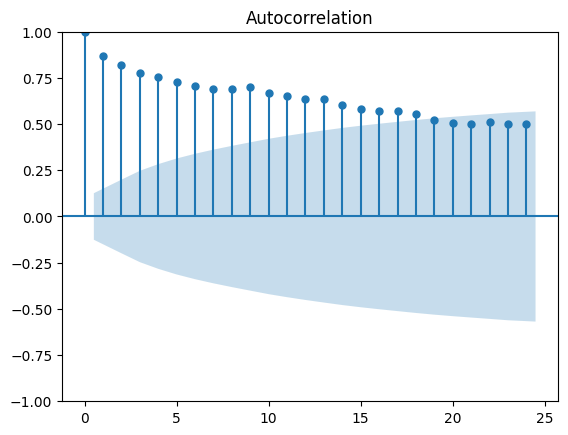

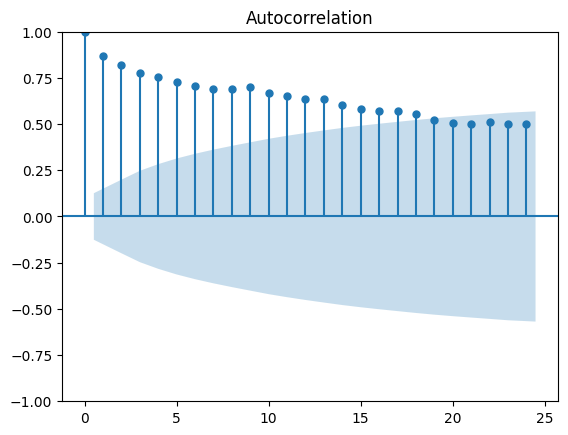

In [45]:
plot_acf(weekly_sales)

The gradual decay in the autocorrelation coefficients as the lag increases indicates that the correlation between the current sales value and its past values diminishes over time. This behavior is typical of time series data that exhibits some form of temporal dependence or trend.


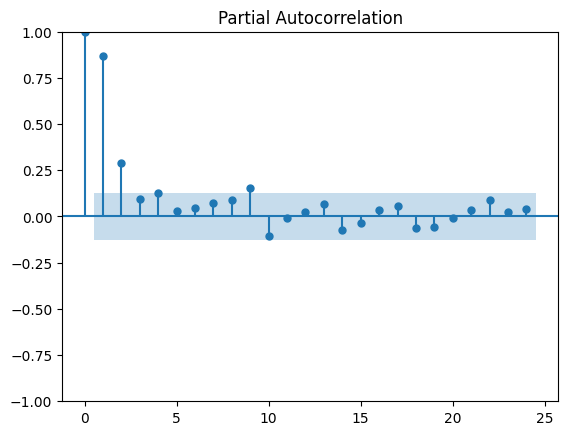

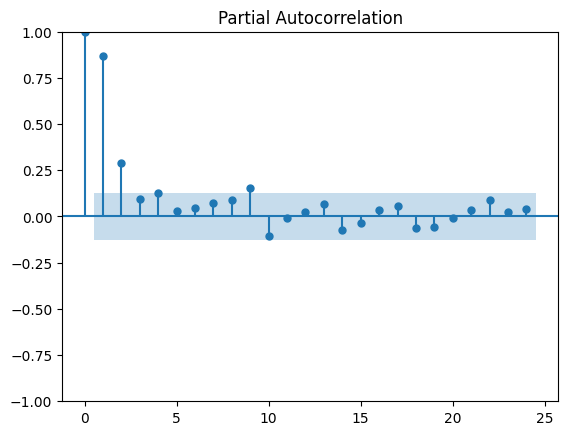

In [46]:
plot_pacf(weekly_sales)

In both images, the PACF plot shows the following patterns:

The first few lags (lag 1, lag 2, and lag 3) have significant partial autocorrelation coefficients that lie outside the confidence intervals (represented by the blue dashed lines).
After lag 3, most of the partial autocorrelation coefficients fall within the confidence intervals, indicating that they are not statistically significant.

This pattern suggests that the "weekly_sales" time series data may potentially be modeled using an Autoregressive (AR) process of order 3 or lower. In an AR(p) model, where p is the order, the current value of the time series is expressed as a linear combination of its previous p values and a random error term.
The specific order of the AR model can be determined by examining the point at which the PACF plot cuts off or becomes insignificant. In this case, the PACF plot appears to cut off after lag 3, indicating that an AR(3) model might be an appropriate choice for modeling the "weekly_sales" data.

# Differencing technique


This process is meant to transform the time series data to stationary, as ARIMA model only works with stationary time series data.

In [47]:
# Group by 'date' and sum 'sales' and 'onpromotion'
train_df_grouped = train_df.groupby('date')[['sales', 'onpromotion']].sum().reset_index()

# Set the index to the 'date' column
train_df_grouped = train_df_grouped.set_index('date')

# Resample the data to weekly frequency and sum the sales
weekly_sales = train_df_grouped['sales'].resample('W').sum()

# Convert the Series to a DataFrame
weekly_sales_df = weekly_sales.to_frame(name='sales')

# Calculate the difference between consecutive weeks' sales
weekly_sales_df['diff_sales'] = weekly_sales_df['sales'].diff()

print(weekly_sales_df.head())

                   sales     diff_sales
date                                   
2013-01-06  2.211570e+06            NaN
2013-01-13  2.373618e+06  162047.368730
2013-01-20  2.368007e+06   -5610.406158
2013-01-27  2.272165e+06  -95842.759951
2013-02-03  2.476891e+06  204726.001130


In [48]:
weekly_sales_df = weekly_sales_df.dropna()

In [49]:
print(weekly_sales_df['diff_sales'])

date
2013-01-13    1.620474e+05
2013-01-20   -5.610406e+03
2013-01-27   -9.584276e+04
2013-02-03    2.047260e+05
2013-02-10   -1.344210e+05
                  ...     
2017-07-23   -4.180265e+03
2017-07-30    1.774767e+05
2017-08-06    4.883817e+05
2017-08-13   -1.024792e+06
2017-08-20   -3.861817e+06
Freq: W-SUN, Name: diff_sales, Length: 241, dtype: float64


In [50]:
weekly_sales_df['diff_sales'] = weekly_sales_df['sales'] - weekly_sales_df['sales'].shift(1)

In [51]:
# Drop the first row since differencing introduces a NaN value
weekly_sales_df = weekly_sales_df.dropna()

In [52]:
print(weekly_sales_df['diff_sales'])

date
2013-01-20   -5.610406e+03
2013-01-27   -9.584276e+04
2013-02-03    2.047260e+05
2013-02-10   -1.344210e+05
2013-02-17    7.813895e+04
                  ...     
2017-07-23   -4.180265e+03
2017-07-30    1.774767e+05
2017-08-06    4.883817e+05
2017-08-13   -1.024792e+06
2017-08-20   -3.861817e+06
Freq: W-SUN, Name: diff_sales, Length: 240, dtype: float64


<ipython-input-53-aa135da846e7>:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(autocorrelation)), autocorrelation, use_line_collection=True)


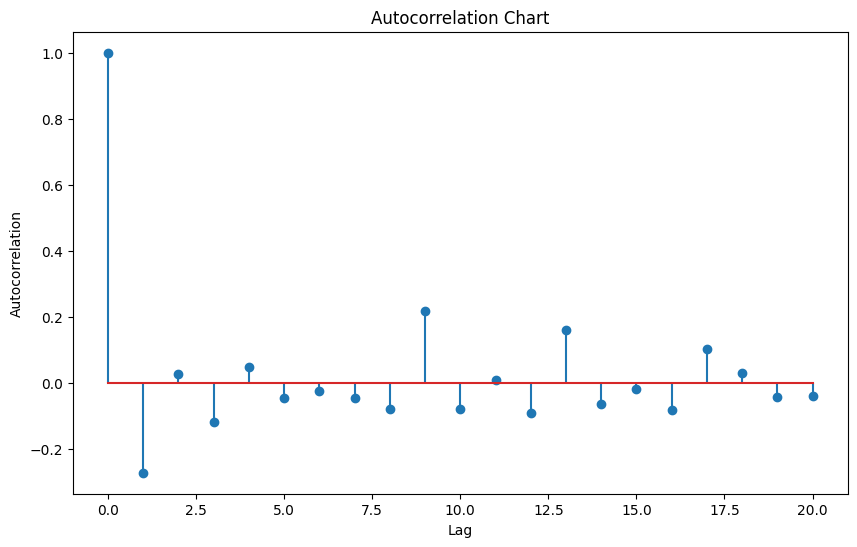

In [53]:
# Compute the autocorrelation
autocorrelation = sm.tsa.acf(weekly_sales_df['diff_sales'], nlags=20)

# Plot the autocorrelation chart
plt.figure(figsize=(10, 6))
plt.stem(range(len(autocorrelation)), autocorrelation, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Chart')
plt.show()

The absence of a clear cutoff or rapid decay in the autocorrelations indicates that the time series may require first-order differencing (d = 1) to remove the trend or non-stationarity.
If the ACF plot of the differenced time series still exhibits a slowly decaying pattern, further differencing (d = 2 or higher) may be required until the ACF plot shows a more rapid decay, indicating stationarity.

# Stationarity Test


There are various statistical tests to check stationarity, including the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

### Augmented Dickey-Fuller (ADF)  test


The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series is stationary or non-stationary. Stationarity is an important assumption in many time series analysis models.

The ADF test evaluates the null hypothesis that the time series has a unit root, indicating non-stationarity. The alternative hypothesis is that the time series is stationary.

When performing the ADF test, we obtain the ADF statistic and the p-value. The ADF statistic is a negative number and the more negative it is, the stronger the evidence against the null hypothesis. The p-value represents the probability of observing the ADF statistic or a more extreme value if the null hypothesis were true. A low p-value (below a chosen significance level, typically 0.05) indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

In [54]:
ts = weekly_sales_df['diff_sales']

In [55]:
# Perform the ADF test
result = adfuller(ts)

# Extract and print the test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

ADF Statistic: -5.9734335335322655
p-value: 1.9121528018799636e-07


ADF Statistic: -5.9734335335322655

This value is quite negative, indicating strong evidence against the null hypothesis of a unit root.

p-value: 1.9121528018799636e-07

This p-value is very small (close to 0), which means that there is very strong evidence against the null hypothesis.

Based on these results, you can reject the null hypothesis that the time series has a unit root. In other words, the time series is stationary.

# Final ACF & PACF

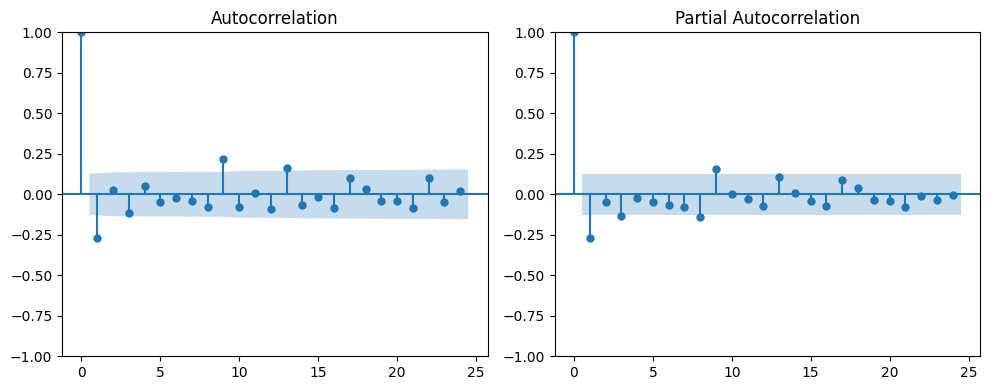

In [56]:
# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plot_acf(weekly_sales_df['diff_sales'], ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
ax2 = plt.subplot(122)
plot_pacf(weekly_sales_df['diff_sales'], ax=ax2)

plt.tight_layout()
plt.show()

The pattern suggests the time series data may be well-represented by an ARIMA(1,1,0) or ARIMA(1,1,1) model, where the data needs to be differenced once to achieve stationarity.

In [57]:
train_df_grouped = train_df.groupby(['date', 'store_nbr', 'product_category'])[['sales', 'onpromotion']].sum().reset_index()
# Set a multi-level index (date, store_nbr, product_category)
train_df_grouped = train_df_grouped.set_index(['date', 'store_nbr', 'product_category'])

# Resample the data to weekly frequency for each group and sum the sales
weekly_sales = train_df_grouped['sales'].groupby([pd.Grouper(level='store_nbr'), pd.Grouper(level='product_category'), pd.Grouper(level='date', freq='W')]).sum().reset_index()

# Print the first few rows to verify
print(weekly_sales.head())

   store_nbr product_category       date  sales
0          1       AUTOMOTIVE 2013-01-06   15.0
1          1       AUTOMOTIVE 2013-01-13   13.0
2          1       AUTOMOTIVE 2013-01-20   13.0
3          1       AUTOMOTIVE 2013-01-27   16.0
4          1       AUTOMOTIVE 2013-02-03   14.0


In [58]:
if isinstance(weekly_sales, pd.core.frame.DataFrame):
    print("df is a Pandas DataFrame")
else:
    print("df is not a Pandas DataFrame")

df is a Pandas DataFrame


In [59]:
# Calculate the mean of 'onpromotion' for each week within each group
weekly_onpromotion_mean = train_df_grouped['onpromotion'].groupby([pd.Grouper(level='store_nbr'), pd.Grouper(level='product_category'), pd.Grouper(level='date', freq='W')]).mean().reset_index()

# Merge weekly_sales and weekly_onpromotion_mean on ['store_nbr', 'product_category', 'date']
weekly_sales_with_promotion = pd.merge(weekly_sales, weekly_onpromotion_mean, on=['store_nbr', 'product_category', 'date'], how='left')

# Print the first few rows to verify
print(weekly_sales_with_promotion.tail())

        store_nbr product_category       date  sales  onpromotion
431239         54          SEAFOOD 2017-07-23   20.0     0.857143
431240         54          SEAFOOD 2017-07-30   25.0     0.571429
431241         54          SEAFOOD 2017-08-06   18.0     0.142857
431242         54          SEAFOOD 2017-08-13   21.0     0.142857
431243         54          SEAFOOD 2017-08-20    3.0     0.000000


In [60]:
onpromotion_min = weekly_sales_with_promotion['onpromotion'].min()
onpromotion_max = weekly_sales_with_promotion['onpromotion'].max()

print(f"Range of onpromotion values: [{onpromotion_min}, {onpromotion_max}]")

Range of onpromotion values: [0.0, 753.2857142857143]


In [61]:
# Set the index to the 'date' column
weekly_sales_with_promotion = weekly_sales_with_promotion.set_index('date')

# Resample the data to weekly frequency and sum the sales
weekly_sales = weekly_sales_with_promotion['sales'].resample('W').sum()

In [64]:
weekly_sales_with_promotion['diff_sales'] = weekly_sales_with_promotion['sales'].diff()

print(weekly_sales_with_promotion.head())

            store_nbr product_category  sales  onpromotion  diff_sales
date                                                                  
2013-01-06          1       AUTOMOTIVE   15.0          0.0         NaN
2013-01-13          1       AUTOMOTIVE   13.0          0.0        -2.0
2013-01-20          1       AUTOMOTIVE   13.0          0.0         0.0
2013-01-27          1       AUTOMOTIVE   16.0          0.0         3.0
2013-02-03          1       AUTOMOTIVE   14.0          0.0        -2.0


In [65]:
weekly_sales_with_promotion = weekly_sales_with_promotion.dropna()

In [66]:
weekly_sales_with_promotion['diff_sales'] = weekly_sales_with_promotion['sales'] - weekly_sales_with_promotion['sales'].shift(1)

<ipython-input-66-a2f2ba04a652>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_sales_with_promotion['diff_sales'] = weekly_sales_with_promotion['sales'] - weekly_sales_with_promotion['sales'].shift(1)


In [67]:
# Drop the first row since differencing introduces a NaN value
weekly_sales_with_promotion = weekly_sales_with_promotion.dropna()

In [68]:
weekly_sales_with_promotion.head()

,store_nbr,product_category,sales,onpromotion,diff_sales
date,,,,,
2013-01-20,1,AUTOMOTIVE,13.0,0.0,0.0
2013-01-27,1,AUTOMOTIVE,16.0,0.0,3.0
2013-02-03,1,AUTOMOTIVE,14.0,0.0,-2.0
2013-02-10,1,AUTOMOTIVE,14.0,0.0,0.0
2013-02-17,1,AUTOMOTIVE,2.0,0.0,-12.0


As we have now observed, even after the changes made to the initial Weekly dataset, the autocorrelations and ACF plots have not altered which leads us to believe that the values of p,d,q that were initially decided upon shall remain the same and now we are ready to run the ARIMA model

In [83]:
weekly_sales_with_promotion = weekly_sales_with_promotion.drop('diff_sales', axis=1)

In [84]:
weekly_sales_with_promotion.head()

,date,store_nbr,product_category,y,onpromotion
0,2013-01-20,1,AUTOMOTIVE,13.0,0.0
1,2013-01-27,1,AUTOMOTIVE,16.0,0.0
2,2013-02-03,1,AUTOMOTIVE,14.0,0.0
3,2013-02-10,1,AUTOMOTIVE,14.0,0.0
4,2013-02-17,1,AUTOMOTIVE,2.0,0.0


### Forecasting Using LSTM

In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping


'''# Extract date components
weekly_sales_with_promotion['year'] = weekly_sales_with_promotion['date'].dt.year
weekly_sales_with_promotion['month'] = weekly_sales_with_promotion['date'].dt.month
weekly_sales_with_promotion['day'] = weekly_sales_with_promotion['date'].dt.day
weekly_sales_with_promotion = weekly_sales_with_promotion.drop('date', axis=1)'''


scaler = StandardScaler()
numerical_cols = ['y', 'onpromotion', 'year', 'month', 'day']
weekly_sales_with_promotion[numerical_cols] = scaler.fit_transform(weekly_sales_with_promotion[numerical_cols])

# Encode categorical variables
encoder = LabelEncoder()
weekly_sales_with_promotion['store_nbr'] = encoder.fit_transform(weekly_sales_with_promotion['store_nbr'])
weekly_sales_with_promotion['product_category'] = encoder.fit_transform(weekly_sales_with_promotion['product_category'])

# Create sequences
X = []
y = []
window = 6  # Window size for creating sequences

for i in range(len(weekly_sales_with_promotion) - window):
    X.append(weekly_sales_with_promotion.iloc[i:i+window, :].values)
    y.append(weekly_sales_with_promotion['y'].iloc[i+window])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile and fit the model
model.compile(optimizer='adam', loss='mse')
# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with fewer epochs and early stopping
model.fit(X_train, y_train, epochs=21, validation_data=(X_test, y_test), callbacks=[early_stop])

INFO:distributed.utils_perf:full garbage collection released 303.76 MiB from 4316 reference cycles (threshold: 9.54 MiB)


Epoch 1/21
10781/10781 [==============================] - 180s 16ms/step - loss: 0.0387 - val_loss: 0.1548
Epoch 2/21
10781/10781 [==============================] - 172s 16ms/step - loss: 0.0305 - val_loss: 0.1125
Epoch 3/21
10781/10781 [==============================] - 174s 16ms/step - loss: 0.0284 - val_loss: 0.1173
Epoch 4/21
10781/10781 [==============================] - 160s 15ms/step - loss: 0.0264 - val_loss: 0.1053
Epoch 5/21
10781/10781 [==============================] - 167s 16ms/step - loss: 0.0251 - val_loss: 0.1009
Epoch 6/21
10781/10781 [==============================] - 169s 16ms/step - loss: 0.0238 - val_loss: 0.1020
Epoch 7/21
10781/10781 [==============================] - 165s 15ms/step - loss: 0.0225 - val_loss: 0.1103
Epoch 8/21
10781/10781 [==============================] - 167s 15ms/step - loss: 0.0215 - val_loss: 0.0865
Epoch 9/21
10781/10781 [==============================] - 165s 15ms/step - loss: 0.0205 - val_loss: 0.0945
Epoch 10/21
10781/10781 [============

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')

2696/2696 [==============================] - 17s 6ms/step
MAE: 0.08
MSE: 0.09
RMSE: 0.29
R-squared: 0.96


In [104]:
weekly_sales_with_promotion.head()

,store_nbr,product_category,y,onpromotion,year,month,day
0,0,0,-0.338155,-0.292004,-1.368818,-1.542841,0.490976
1,0,0,-0.337750,-0.292004,-1.368818,-1.542841,1.288405
2,0,0,-0.338020,-0.292004,-1.368818,-1.246988,-1.445638
3,0,0,-0.338020,-0.292004,-1.368818,-1.246988,-0.648209
4,0,0,-0.339641,-0.292004,-1.368818,-1.246988,0.149220


In [108]:
test_df_new = pd.read_csv('test_new.csv')


In [109]:
test_df_new.head()

,store_nbr,product_category,onpromotion,year,month,day
0,0,0,-0.505838,0.0,-0.707107,0.330771
1,0,0,-0.505838,0.0,-0.707107,1.025389
2,0,0,-0.505838,0.0,1.414214,-1.356159
3,0,1,-0.505838,0.0,-0.707107,0.330771
4,0,1,-0.505838,0.0,-0.707107,1.025389


In [111]:
print(test_df_new.dtypes)

store_nbr             int64
product_category      int64
onpromotion         float64
year                float64
month               float64
day                 float64
dtype: object


In [115]:
X_test = []
window = 6
dummy_value = 0  # or any other suitable value

for i in range(len(test_df_new) - window + 1):
    sequence = test_df_new.iloc[i:i+window].values
    sequence = np.insert(sequence, sequence.shape[1], dummy_value, axis=1)
    X_test.append(sequence)

X_test = np.array(X_test)

# Make predictions
predictions = model.predict(X_test)

167/167 [==============================] - 1s 6ms/step


In [116]:
print(predictions)

[[-0.42745763]
 [-0.3512364 ]
 [-0.40657765]
 ...
 [-0.3790186 ]
 [-0.30592197]
 [-0.3706985 ]]


In [121]:
# Convert predictions to a pandas Series
predictions_series = pd.Series(predictions.flatten(), name='y')

# Concatenate the predictions_series with the original test_df_new DataFrame
test_df_new = pd.concat([test_df_new, predictions_series], axis=1)


In [122]:
test_df_new.head()

,store_nbr,product_category,onpromotion,year,month,day,y
0,0,0,-0.505838,0.0,-0.707107,0.330771,-0.427458
1,0,0,-0.505838,0.0,-0.707107,1.025389,-0.351236
2,0,0,-0.505838,0.0,1.414214,-1.356159,-0.406578
3,0,1,-0.505838,0.0,-0.707107,0.330771,-0.407033
4,0,1,-0.505838,0.0,-0.707107,1.025389,0.595406


In [128]:
test_df_new.to_csv('predictions.csv', index=False)